# Analysis of fractional distance

To determine whether more data equates to reaching a canonical form of the reconstructions we performed ASR on a number of varying sized alignments for two datasets, DHAD and KARI. 

The reconstrcutions were generated by using GRASP as as 11/2019. All reconstructions are using joint reconstructions and only the consensus sequence is considered.

Method to determine the fractional distance:

```
    1. Load reconstructed tree (output of GRASP) 
    2. Choose the smallest tree as the reference
    3. For every tree, with resepcted to the reference tree from (2), calculate equivalent nodes in the larger tree
    4. Pick several nodes to inspect from (2)
    5. Using the downloaded consensus sequences from GRASP, load the alignment and pull out the consensus sequence for equivalent nodes in each of the alignments using the dictionary created in (3)
    6. Remove all the gaps for each set of sequences from 5
    7. Sort the sequences from (6) so that they are in order from smallest alignment to largest and align sequences from (6) using MAFFT
    8. Reload the alignment and calculate the fractional distances using binfpy
    9. Plot heatmaps
    
```

## Useful functions below (used for the analysis and visualisation)

The functions below are used for each analysis, don't need to be read in detail (except for write_heatmap)

In [ ]:
import pandas as pd
import sys
import os
import seaborn as sns
sys.path.append('./src/binfpy')
sys.path.append('./src/SimilarNodeFinder/src')

import sequence
import webservice
import numpy as np
import pickle
import csv
import scipy.stats as stats
import matplotlib.pyplot as plt
from tree_object import TreeObject
from tree_controller import TreeController
from scipy.stats import pearsonr


cyp2_str = 'CYP2'
kari_str = 'KARI1'
dhad_str = 'DHAD'



# Choose your colour
colour_map = "Greens"
colour_map = "BuPu"
colour_map = "YlGnBu"
colour_map = "Blues"
colour_map = "mako"
colour_map = "PiYG"
colour_map = "gist_rainbow"
# Would recommend the below
colour_map = "BuPu"
colour_map = "viridis"
colour_map = "BuPu_r"
# Set the number of ticks between each tick, one means every label is showing
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']


n_ticks = 1

def save_plt(fig, name, dpi=300):
    # Old version of save fig doesn't make it high res.
    fig.savefig(name, format = "png", bbox_inches = 'tight', pad_inches = 0, dpi=dpi)


def generate_alignment(filename):
    filename_fasta = filename + '.fa'
    filename_aln = filename + '.aln'
    ! mafft --auto --quiet --thread 4 $filename_fasta > $filename_aln

def writeToCsv(writer, num_seqs, node_name, seq_name, dists):
    """
    Helper to write to the csv file
    """
    to_write = [str(num_seqs), str(node_name), str(seq_name),]
    
    for d in dists:
        to_write.append(str(d))

    writer.writerow(to_write)


import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

               
def plotFracHeatmap(df, node, labels, vmax=0.6):
    fig, ax = plt.subplots()
    
    im, cbar = heatmap(df[fact_names], labels, labels, node + " fractional distance", ax=ax, cmap="BuPu", cbarlabel="Distance")#, vmax=vmax)
    plt.show()
    return fig

def heatmap(data, row_labels, col_labels, title, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Arguments:
        data       : A 2D numpy array of shape (N,M)
        row_labels : A list or array of length N with the labels
                     for the rows
        col_labels : A list or array of length M with the labels
                     for the columns
    Optional arguments:
        ax         : A matplotlib.axes.Axes instance to which the heatmap
                     is plotted. If not provided, use current axes or
                     create a new one.
        cbar_kw    : A dictionary with arguments to
                     :meth:`matplotlib.Figure.colorbar`.
        cbarlabel  : The label for the colorbar
    All other arguments are directly passed on to the imshow call.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labelling appear on top.

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    # ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)
    ax.set_title(title)
    
    return im, cbar

def write_heatmap(output_dir_str, sequences_of_interest, node_name_dict):
    """
    
    Calculates the file for the heatmap creation. This involves aligning all the sequences 
    (from the various reconstructions) for each node of interest.
    Then re-reading this in and calculating the fractional distance.
    
    We also keep track of the average length of sequences for a given node (just out of interest)
    and print these results
    
    """
    with open(output_dir_str, 'w+') as output_writer:
        writer = csv.writer(output_writer, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        row = ['num_seqs', 'aln_name', 'seq_name']
        # Write the first row
        for s in sequences_of_interest:
            row.append(str(s))
        # Write our header row
        writer.writerow(row)
        
        # Here we want to iterate through our node dictionary and get all the consensus sequences
        # we're interested in. These are by default gappy.
        for node in node_name_dict:
            # Get the consensus sequences from all the reconstructions for that node (e.g. N1 would have sequences
            # from recon1, recon2 etc.)
            # Write this to a file
            outfilename = output_dir_str.split('.')[0] + node 
            seqs_all = node_name_dict[node]['seqs']
            seqs_dict = {}
            seqs_names = []
            # Now we want to build up a dictionary of the names to the sequences so we can order them easily
            for s in seqs_all:
                seqs_names.append(s.name)
                seqs_dict[s.name] = s
            seqs = []
            # Order the names
            seqs_names.sort()
            # Recreate a list of sequences now in a sorted order
            for s in seqs_names:
                seqs.append(seqs_dict[s])

            non_gappy_seqs = []
            seq_lens = []
            # Now we want to save this as an alignment, but we want to remove the gaps
            for s in seqs:
                count_no_gaps = 0
                no_gap = ''
                for c in s:
                    if c != '-':
                        count_no_gaps += 1
                        no_gap += c
                # Create a new sequence object just with the gaps removed
                non_gappy_seqs.append(sequence.Sequence(no_gap, sequence.Protein_Alphabet, name=s.name))
                seq_lens.append(count_no_gaps)

            # Calculate various metrics for the length
            var_lens = np.var(seq_lens)
            sd_lens = np.std(seq_lens)
            mean_len = np.mean(seq_lens)
            median_len = np.median(seq_lens)
            print("-------------- " + node + '-------------')
            print('var: ', var_lens, ', stdev: ', sd_lens, ', mean: ', mean_len, ', median: ', median_len)

            # Write this to a fasta file and generate an alignemnt from this
            sequence.writeFastaFile(outfilename + '.fa', non_gappy_seqs)

            generate_alignment(outfilename)

            # Read in the aligned sequences and from this determine the consensus etc.
            seqs_aligned = sequence.readFastaFile(outfilename + '.aln', sequence.Protein_Alphabet, gappy=True)

            alignment = sequence.Alignment(seqs_aligned)

            # For each sequence in the alignment calculate the divergence from the consensus using fractional
            distances = alignment.calcDistances("fractional")
            seq_dists = {}
            # Now we want to assign the distances to a given sequence (so we can again ensure the order is maintained)
            for s_idx in range(0, len(seqs_aligned)):
                seq = seqs_aligned[s_idx]
                dists = distances[s_idx]
                seq_dists[seq.name] = dists
            # Finally for each sequence, write it to a file
            for seq in seqs:     
                writeToCsv(writer, seq.name.split('_')[0], node, seq.name, seq_dists[seq.name])


# DHAD

First we will analyse the DHADs. These were made using a base dataset of 1612. However, we will calculate the nodes with respect to an original tree of 585 sequences, titled sp_cured_3_01112018_reconstructed-tree_GRASP.nwk

There are 16 datasets, each 500 sequences more than the preceding until we reach 9112 sequences. 



### (1 - 3) Load the trees and calculate the matching nodes to our reference


In [ ]:
from tree_object import TreeObject
from tree_controller import TreeController

input_dir_str = 'Files/PIA_1_Files/GRASP_recons/' + dhad_str + '/'
output_dir_str = 'Files/PIA_1_Files/output/'


trees = []
files = os.listdir(input_dir_str)
for f in files:
    if '.nwk' in f:
        trees.append(f)

# Choose the base tree
base_tree = 'sp_cured_3_01112018_reconstructed-tree_GRASP.nwk'
node_matching_dict = {}

# Create our node matching dictionary, print out if we get any errors.
for t in trees:
    try:
        t1 = TreeObject(input_dir_str + base_tree) 
        t2 = TreeObject(input_dir_str + t)
        tc = TreeController()
        node_matching = tc.get_similar_nodes_between_trees(t1, t2, True)
        node_matching_dict[t] = node_matching
        print("Complete: " + t)
    except Exception as e:
        print(e)

### (4) Find the matching nodes in the larger trees for our chosen nodes of interest

In [ ]:
# Here we make our main dictionary using the node identifiers for our base/reference tree
node_name_dict = {'N1': {'seqs': []}, 'N423': {'seqs': []}, 'N560': {'seqs': []}}

nodes = ['N1', 'N423', 'N560']

for t, tree in node_matching_dict.items():
    for n in nodes:
        try:
            """
            Here we're using t_num as our method for matching our trees and our alignments, this
            will be specific to each dataset. Our trees are: r_1000_2612_dhad_18032019.nwk_recon.nwk
            So by spliting on _ and taking the 1st element, we get 1000 for the tree above.          
            """
            t_num = t.split('_')[1]
            node_name_dict[n][t_num] = tree.get(n).original_label
            print("Matched: \t" + n + "\t -> \t" + tree.get(n).get_label())
        except Exception as e:
            print(n, t, e)


### (5) Load in the alignments

In [ ]:
dhad_files = []
files = os.listdir(input_dir_str)
for f in files:
    if '.aln' in f:
        dhad_files.append(f)

print(dhad_files)

### (6) Pick out the consensus sequences from each alignment for our nodes of interest

In [ ]:
"""
Here we want to iterate through our alignment files (dhad_files) and pick out the consensus
sequences that match with our base/reference tree nodes of interest
"""
for f in dhad_files:
    lengths = []
    num_seqs = []
    # Read in the fasta file. This is the output of GRASP (for the joint consensus ancestors)
    seqs_aligned = sequence.readFastaFile(input_dir_str + f, sequence.Protein_Alphabet, gappy=True)
    seq_dict = {}
    for seq in seqs_aligned:
        seq_dict[seq.name] = seq
    i = 0
    """
    Here we want a string to match between our reconstructed trees and our alignments from GRASP
    For here our trees are annotated as: r_5500_7112_dhad_18032019.nwk_recon.nwk
    and our alignments as: recon_5500.aln
    Thus we want to match the 5500 from the tree to the 5500 from the alignment

    """
    match_string = f.split('_')[1].split('.')[0]
    # Check if this is a sequence of interest
    for node_name, node_dict in node_name_dict.items():
        for seq_nums, matching_node_name in node_dict.items():
            if seq_nums == match_string:
                s = seq_dict[matching_node_name]
                no_gap = ''
                for c in s:
                    if c != '-':
                        no_gap += c
                seq = sequence.Sequence(no_gap, sequence.Protein_Alphabet, name=seq_nums + '_' + s.name)
                node_dict['seqs'].append(seq)
    print("Finished: \t" + f + " \t Matched: " + str(len(node_dict['seqs'])) + " nodes")
    i += 1


### (7 - 8) Calculate the fractional distances

Now we have the sequences for each of the nodes, we want to:
```
1. Remove all the gaps
2. Create an alignment of the sequences
3. Calculate the fractional distances from these
```

In [ ]:
# Write out which sequences were interested in (this is really the alignment names, so number of sequences)
sequences_of_interest = [1612, 2112, 2612, 3112, 3612, 4112, 4612, 5112, 5612, 6112, 6612, 7112, 7612, 8112, 8612, 9112]

# Write heatmap calculates the fractional distances
write_heatmap(output_dir_str + 'DHAD_heatmap.csv', sequences_of_interest, node_name_dict)


### (9) Plot the heatmaps using the file that we just wrote

In [ ]:

csv_file_name = output_dir_str + 'DHAD_heatmap.csv'
nodes_of_interest = ['N1', 'N423', 'N560']
sequences_of_interest = [1612, 2112, 2612, 3112, 3612, 4112, 4612, 5112, 5612, 6112, 6612, 7112, 7612, 8112, 8612, 9112]
                         
# Read in the csv
df = pd.read_csv(csv_file_name)

# Ensure our names are strings
fact_names = []
for n in sequences_of_interest:
    fact_names.append(str(n))

# Group the data
df_N1 = df[df['aln_name'] == 'N1']
df_N423 = df[df['aln_name'] == 'N423']
df_N560 = df[df['aln_name'] == 'N560']

# Plot the heatmaps
fig = plotFracHeatmap(df_N1, "N1", sequences_of_interest, vmax=0.4)
save_plt(fig, output_dir_str + 'DHAD_N1_heatmap_frac_dist.png')

fig = plotFracHeatmap(df_N423, "N423", sequences_of_interest, vmax=0.4)
save_plt(fig, output_dir_str + 'DHAD_N423_heatmap_frac_dist.png')

fig = plotFracHeatmap(df_N560, "N560", sequences_of_interest, vmax=0.4)
save_plt(fig, output_dir_str + 'DHAD_N560_heatmap_frac_dist.png')



# Repeat the analysis for CYP2

Here we want to run the same analysis as above, but on the CYP2 dataset. Here rather than randomly adding sequences
we're looking at adding families of proteins. 

We have the CYP2U1, CYP2R, and CYP2D.


### (1 - 3) Load the trees and calculate the matching nodes to our reference

In [10]:
from tree_object import TreeObject
from tree_controller import TreeController

input_dir_str = 'Files/PIA_1_Files/GRASP_recons/' + cyp2_str + '/'
output_dir_str = 'Files/PIA_1_Files/output/'

trees = []
files = os.listdir(input_dir_str)
for f in files:
    if '.nwk' in f:
        trees.append(f)

print(trees)

['20191812_CYP2U-CYP2R-CYP2D_Paper_Version_reconstructed-tree_GRASP.nwk', '20191216_CYP2U-CYP2R_Paper_Version_reconstructed-tree_GRASP.nwk', '20191216_CYP2U_Paper_Version_reconstructed-tree_GRASP.nwk']


### (4) Find the matching nodes in the larger trees for our chosen nodes of interest

In [11]:
base_tree = '20191216_CYP2U_Paper_Version_reconstructed-tree_GRASP.nwk'
nodes = ['N0', 'N1', 'N4']
node_name_dict = {'N0': {'seqs': []}, 'N1': {'seqs': []}, 'N4': {'seqs': []}}

nodes = ['N0', 'N1', 'N4']
node_matching_dict = {}
for t in trees:
    t1 = TreeObject(input_dir_str + base_tree) 
    t2 = TreeObject(input_dir_str + t)
    tc = TreeController()
    t_num = t.split('_')[1]
    node_matching = tc.get_similar_nodes_between_trees(t1, t2, True)
    node_matching_dict[t] = node_matching
    
    for label_original, label_match in node_matching.items():
        if label_original == 'N0':
            print(label_original, label_match.get_label())
            
    for n in nodes:
        node_name_dict[n][t_num] = node_matching_dict[t][n].get_label()
        print(n, node_matching_dict[t][n].get_label())
    print("Complete: " + t)
print(node_name_dict)

N0 N1
N0 N1
N1 N2
N4 N5
Complete: 20191812_CYP2U-CYP2R-CYP2D_Paper_Version_reconstructed-tree_GRASP.nwk
N0 N1
N0 N1
N1 N2
N4 N123
Complete: 20191216_CYP2U-CYP2R_Paper_Version_reconstructed-tree_GRASP.nwk
N0 N0
N0 N0
N1 N1
N4 N4
Complete: 20191216_CYP2U_Paper_Version_reconstructed-tree_GRASP.nwk
{'N0': {'seqs': [], 'CYP2U-CYP2R-CYP2D': 'N1', 'CYP2U-CYP2R': 'N1', 'CYP2U': 'N0'}, 'N1': {'seqs': [], 'CYP2U-CYP2R-CYP2D': 'N2', 'CYP2U-CYP2R': 'N2', 'CYP2U': 'N1'}, 'N4': {'seqs': [], 'CYP2U-CYP2R-CYP2D': 'N5', 'CYP2U-CYP2R': 'N123', 'CYP2U': 'N4'}}


### (5) Load in the alignments

In [12]:
cyp2_files = []
sequences_of_interest = []

files = os.listdir(input_dir_str)
for f in files:
    if '.fasta' in f:
        cyp2_files.append(f)
        # Use the 2U-2R-2D as the order
        sequences_of_interest.append(f.split('_')[1])
        
print(cyp2_files)

['20191812_CYP2U-CYP2R-CYP2D_Paper_Version_joint-ancestors_GRASP.fasta', '20191216_CYP2U-CYP2R_Paper_Version_joint-ancestors_GRASP.fasta', '20191216_CYP2U_Paper_Version_joint-ancestors_GRASP.fasta']


### (6) Pick out the consensus sequences from each alignment for our nodes of interest

In [13]:
# Again build up our node_name_dict using our sequences of interest


for t, tree in node_matching_dict.items():
    for n in nodes:
        try:
            """
            Here we're using t_num as our method for matching our trees and our alignments, this
            will be specific to each dataset. Our trees are: 20191216_CYP2U-CYP2R_Paper_Version_reconstructed-tree_GRASP.nwk
            So by splitting on _ and taking the 1st element, we get 2 for the tree above, 
            20191216_CYP2U-CYP2R_Paper_Version_reconstructed-tree_GRASP.nwk = CYP2U-CYP2R etc.        
            """
            t_num = t.split('_')[1]
            node_name_dict[n][t_num] = tree.get(n).original_label
            print("Matched: \t" + n + "\t -> \t" + tree.get(n).get_label())
        except Exception as e:
            print(n, t, e)
            

Matched: 	N0	 -> 	N1
Matched: 	N1	 -> 	N2
Matched: 	N4	 -> 	N5
Matched: 	N0	 -> 	N1
Matched: 	N1	 -> 	N2
Matched: 	N4	 -> 	N123
Matched: 	N0	 -> 	N0
Matched: 	N1	 -> 	N1
Matched: 	N4	 -> 	N4


In [14]:
"""
Here we want to iterate through our alignment files and pick out the consensus
sequences that match with our base/reference tree nodes of interest
"""
for f in cyp2_files:
    lengths = []
    num_seqs = []
    seqs_aligned = sequence.readFastaFile(input_dir_str + f, sequence.Protein_Alphabet, gappy=True)
    seq_dict = {}
    for seq in seqs_aligned:
        seq_dict[seq.name] = seq
    i = 0
    """
    UNIQUE TO EACH DATASET:
        
    Here we want a string to match between our reconstructed trees and our alignments from GRASP
    For here our trees are annotated as: 20191216_CYP2U-CYP2R_Paper_Version_reconstructed-tree_GRASP.nwk
    and our alignments as: 20191216_CYP2U-CYP2R-CYP2D_Paper_Version_joint-ancestors_GRASP.fasta 
    Thus we want to match the [2] from the tree with the [2] from the alignment

    """
    num_seqs = f.split('_')[1]
    
    # Check if this is a sequence of interest
    for node_name, node_dict in node_name_dict.items():
        for seq_nums, matching_node_name in node_dict.items():
            if seq_nums == num_seqs:
                s = seq_dict[matching_node_name]
                no_gap = ''
                for c in s:
                    if c != '-':
                        no_gap += c
                seq = sequence.Sequence(no_gap, sequence.Protein_Alphabet, name=seq_nums + '_' + s.name)
                node_dict['seqs'].append(seq)
                
    print("Finished: \t" + f + " \t Matched: " + str(len(node_dict['seqs'])) + " nodes")
    i += 1



Finished: 	20191812_CYP2U-CYP2R-CYP2D_Paper_Version_joint-ancestors_GRASP.fasta 	 Matched: 1 nodes
Finished: 	20191216_CYP2U-CYP2R_Paper_Version_joint-ancestors_GRASP.fasta 	 Matched: 2 nodes
Finished: 	20191216_CYP2U_Paper_Version_joint-ancestors_GRASP.fasta 	 Matched: 3 nodes


### (7 - 8) Calculate the fractional distances

Now we have the sequences for each of the nodes, we want to:
```
1. Remove all the gaps
2. Create an alignment of the sequences
3. Calculate the fractional distances from these
```

In [15]:
# Write out which sequecnes were interested in (this is really the alignment names, so number of sequences)
print(sequences_of_interest, node_name_dict)
write_heatmap(output_dir_str + 'CYP2_heatmap.csv', sequences_of_interest, node_name_dict)

['CYP2U-CYP2R-CYP2D', 'CYP2U-CYP2R', 'CYP2U'] {'N0': {'seqs': [<sequence.Sequence object at 0x12872bb00>, <sequence.Sequence object at 0x1289e0f60>, <sequence.Sequence object at 0x1289f4048>], 'CYP2U-CYP2R-CYP2D': 'N1', 'CYP2U-CYP2R': 'N1', 'CYP2U': 'N0'}, 'N1': {'seqs': [<sequence.Sequence object at 0x12872bac8>, <sequence.Sequence object at 0x1289e0f28>, <sequence.Sequence object at 0x1289f4080>], 'CYP2U-CYP2R-CYP2D': 'N2', 'CYP2U-CYP2R': 'N2', 'CYP2U': 'N1'}, 'N4': {'seqs': [<sequence.Sequence object at 0x12872ba20>, <sequence.Sequence object at 0x1289e0e80>, <sequence.Sequence object at 0x1289f2f98>], 'CYP2U-CYP2R-CYP2D': 'N5', 'CYP2U-CYP2R': 'N123', 'CYP2U': 'N4'}}
-------------- N0-------------
var:  8.666666666666666 , stdev:  2.943920288775949 , mean:  486.0 , median:  485.0
-------------- N1-------------
var:  8.666666666666666 , stdev:  2.943920288775949 , mean:  486.0 , median:  485.0
-------------- N4-------------
var:  0.888888888888889 , stdev:  0.9428090415820634 , mean:

### Calculate the size and variation of the sequences

For each node of interest calculate the size and differences for each of these




In [16]:
variances = []
medians = []
means = []
corelations = []

for node_name, node in node_name_dict.items():
    seqs = node['seqs']
    seq_lens = []
    # Now for each sequence we want to get the length (no gaps)
    for seq in seqs:
        seq_len = 0
        for i in seq:
            if i != '-':
                seq_len += 1
        seq_lens.append(seq_len)
    print(node_name, np.var(seq_lens), np.mean(seq_lens), np.median(seq_lens))
    

N0 8.666666666666666 486.0 485.0
N1 8.666666666666666 486.0 485.0
N4 0.888888888888889 490.3333333333333 491.0


### (9) Plot heatmap

['CYP2U-CYP2R-CYP2D', 'CYP2U-CYP2R', 'CYP2U']


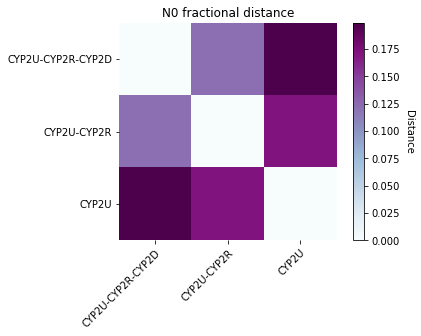

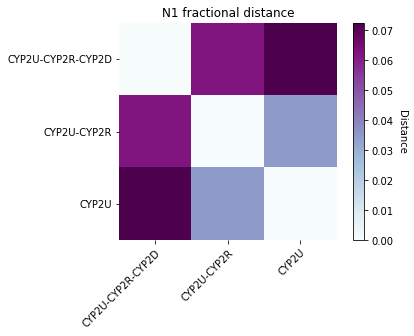

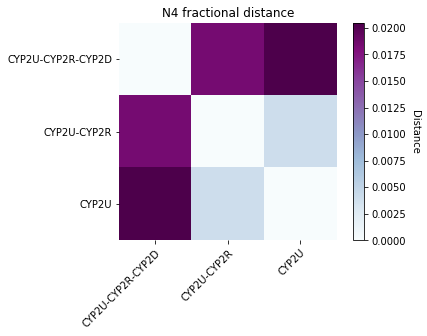

In [17]:

csv_file_name = output_dir_str + 'CYP2_heatmap.csv'
df = pd.read_csv(csv_file_name)
fact_names = []
for n in sequences_of_interest:
    fact_names.append(str(n))

print(fact_names)
df_N0 = df[df['aln_name'] == 'N0']
df_N1 = df[df['aln_name'] == 'N1']
df_N4 = df[df['aln_name'] == 'N4']


fig = plotFracHeatmap(df_N0, "N0", sequences_of_interest, vmax=0.6)
save_plt(fig, output_dir_str + 'CYP2_N0_heatmap_frac_dist.png')

fig = plotFracHeatmap(df_N1, "N1", sequences_of_interest, vmax=0.6)
save_plt(fig, output_dir_str + 'CYP2_N1_heatmap_frac_dist.png')

fig = plotFracHeatmap(df_N4, "N4", sequences_of_interest, vmax=0.6)
save_plt(fig, output_dir_str + 'CYP2_N4_heatmap_frac_dist.png')


